In [1]:
from matplotlib.cm import ScalarMappable
import numpy as np
import h5py
from pathlib import Path
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import ticker
from matplotlib.colors import Normalize
import numpy as np
import h5py
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import  extract_mesh, extract_element_thickness, extract_point_springback, extract_point_cloud
import torch
from tqdm import tqdm
import time
from pathlib import Path

In [2]:
data_dir = Path("/mnt/data/darus/")

dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

# Display sample simulation
sim_id, metadata, h5_path = dataset[0]
print(f"Sample simulation: {sim_id}")
print(f"File: {h5_path}")
print(f"Metadata: {metadata}")

try:
    import scienceplots

    plt.style.use(["science"])
except ImportError as exc:
    print("For proper plotting, use scienceplots")

# Standard figure sizes (width, height) in inches based on paper dimensions.
FIGURE_SIZES = {
    "single_col": (3.5, 2.6),  # Single column
    "single_col_cb": (5, 3.5),  # Single column, with colorbar
    "single_col_tall": (3.5, 3.5),  # Single column, square-ish
    "double_col": (7.0, 3.0),  # Double column, wide
    "double_col_tall": (7.0, 4.5),  # Double column, taller
    "square": (3.5, 3.5),  # Square single column
    "poster": (10, 8),  # For presentations/posters
}

# Visualization constants for consistency
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

# Component settings
COMPONENT_COLORS = {"blank": "red"}
COMPONENT_NAMES = {
    "blank": "Blank (Workpiece)",
}


Loaded 32071 simulations
Sample simulation: 16039
File: /mnt/data/darus/h5/16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]
For proper plotting, use scienceplots


In [3]:

# Variables
OPERATION = 10  # Can be 10 or 20.

# Get springback information
final_coords, displacement_vectors = extract_point_springback(
    h5_path, operation=OPERATION
)
node_coords, triangles = extract_mesh(h5_path, operation=OPERATION, component='blank', timestep = 2)

final_coords_test = node_coords + displacement_vectors

# Calculate displacement magnitude for color mapping
displacement_magnitude = np.linalg.norm(displacement_vectors, axis=1)

# Settings for plotting.
global_springback_min = 0.0
global_springback_max = 1.4

# Statistics
print(f"Springback statistics:")
print(f" - Mean magnitude: {displacement_magnitude.mean():.4f} mm")
print(f" - Max magnitude: {displacement_magnitude.max():.4f} mm")
print(f" - Min magnitude: {displacement_magnitude.min():.4f} mm")
print(f" - Std deviation: {displacement_magnitude.std():.4f} mm")

Springback statistics:
 - Mean magnitude: 0.2124 mm
 - Max magnitude: 0.7167 mm
 - Min magnitude: 0.0000 mm
 - Std deviation: 0.1983 mm


<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_258335/3470324508.py:70: SyntaxWarning: invalid escape sequence '\&'
  ax.set_title(f"Original Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")


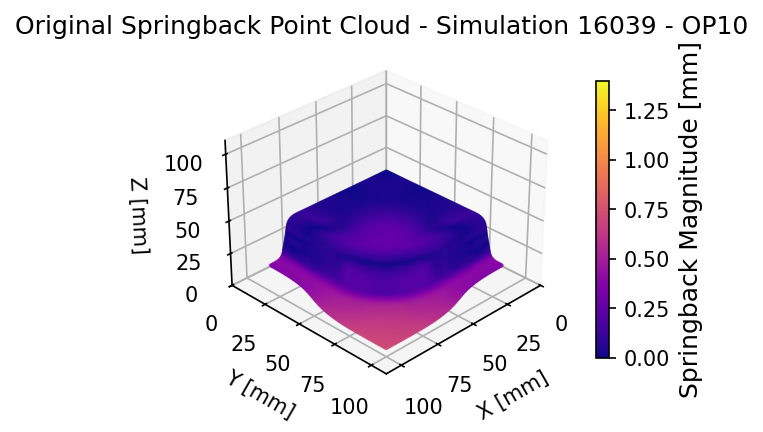

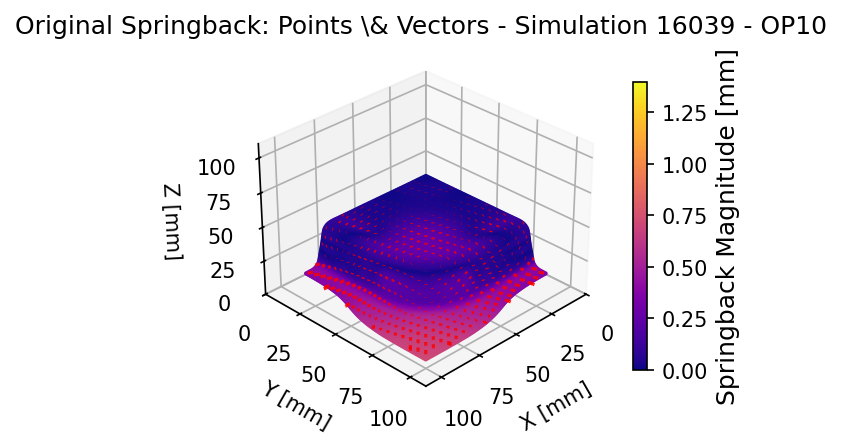

In [4]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection="3d")

norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
colors = plt.cm.plasma(norm(displacement_magnitude))


scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=0.8
)

sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Original Springback Point Cloud - Simulation {sim_id} - OP{OPERATION}")

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

# Variables
STEP = 25  # Resolution/Amount of arrows
SCALING = 10  # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection="3d")

scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=1
)

# Vectors (subsampled)
coords_sub = final_coords[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(
    coords_sub[:, 0],
    coords_sub[:, 1],
    coords_sub[:, 2],
    vectors_sub[:, 0],
    vectors_sub[:, 1],
    vectors_sub[:, 2],
    color="red",
    alpha=0.8,
    arrow_length_ratio=0.1,
)


sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Original Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}")

plt.show()

In [ ]:
import os
import numpy as np
   
OPERATION = 10                        # or 20
sample_id = "16039"                   
pred_dir  = "/home/RUS_CIP/st186731/Grit/GRIT/results/ddacs-node-regression/preds_new/"
data_root = "/mnt/data/jiang"         

# Get mesh (coords + triangles)
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=2
)                                      # node_coords: (N,3)

# Load predicted displacement (N,3)
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
displacement_vectors = np.load(pred_path)    # (N,3)

idx_path = os.path.join(data_root, f"{sample_id}_node_index.npy")
if os.path.exists(idx_path):
    node_index = np.load(idx_path)     # shape (N,)
    # reorder predictions so they match mesh/node_coords order
    order = np.argsort(node_index)
    displacement_vectors = displacement_vectors[order]

# Sanity check
assert displacement_vectors.shape == node_coords.shape, \
    f"shape mismatch: preds {displacement_vectors.shape} vs coords {node_coords.shape}"

# Apply displacement
final_coords = node_coords + displacement_vectors

# Magnitudes for coloring / stats
displacement_magnitude = np.linalg.norm(displacement_vectors, axis=1)

# Stats
print("Springback statistics (pred):")
print(f" - Mean magnitude: {displacement_magnitude.mean():.4f}")
print(f" - Max magnitude:  {displacement_magnitude.max():.4f}")
print(f" - Min magnitude:  {displacement_magnitude.min():.4f}")
print(f" - Std deviation:  {displacement_magnitude.std():.4f}")

#   plotting with existing routine
global_springback_min = 0.0
global_springback_max = 1.4
# plot_mesh(final_coords, triangles, displacement_magnitude, vmin=global_springback_min, vmax=global_springback_max)


Springback statistics (pred):
 - Mean magnitude: 0.1969
 - Max magnitude:  0.4673
 - Min magnitude:  0.0015
 - Std deviation:  0.1305


<>:70: SyntaxWarning: invalid escape sequence '\&'
<>:70: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_233695/2223343093.py:70: SyntaxWarning: invalid escape sequence '\&'
  ax.set_title(f"Predicted Springback: Points \& Vectors - Simulation {sample_id} - OP{OPERATION}")


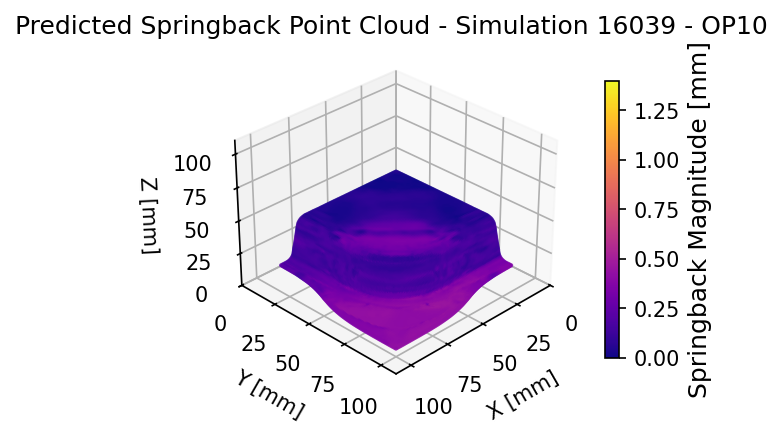

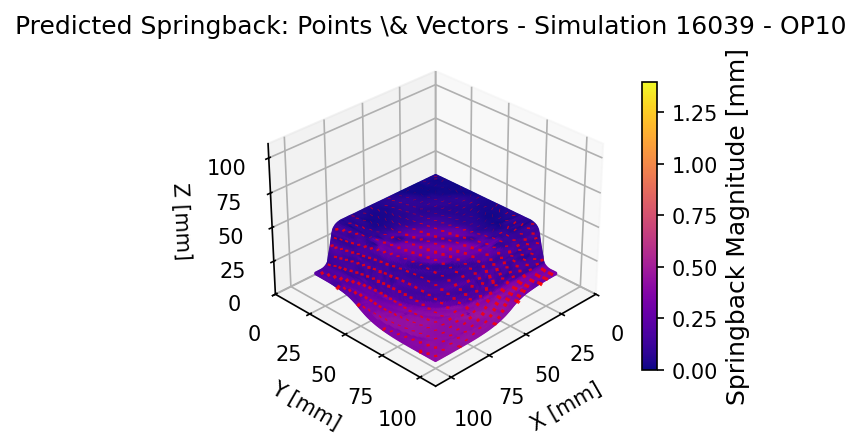

In [53]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection="3d")

norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
colors = plt.cm.plasma(norm(displacement_magnitude))


scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=0.8
)

sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Predicted Springback Point Cloud - Simulation {sample_id} - OP{OPERATION}")

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

# Variables
STEP = 25  # Resolution/Amount of arrows
SCALING = 10  # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection="3d")

scatter = ax.scatter(
    final_coords[:, 0], final_coords[:, 1], final_coords[:, 2], c=colors, s=1, alpha=1
)

# Vectors (subsampled)
coords_sub = final_coords[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(
    coords_sub[:, 0],
    coords_sub[:, 1],
    coords_sub[:, 2],
    vectors_sub[:, 0],
    vectors_sub[:, 1],
    vectors_sub[:, 2],
    color="red",
    alpha=0.8,
    arrow_length_ratio=0.1,
)


sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
cbar.set_label("Springback Magnitude [mm]", fontsize=12)

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title(f"Predicted Springback: Points \& Vectors - Simulation {sample_id} - OP{OPERATION}")

plt.show()

Loaded 32071 simulations
Using sample 16039 → /mnt/data/darus/h5/16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]

--- Springback stats ---
Ground_Truth    : mean=0.2124,  max=0.7167,  std=0.1983
Prediction  : mean=0.1994, max=0.5470, std=0.1534
Difference : mean=0.0929,  max=0.4304,  std=0.0544


/tmp/ipykernel_1688313/3059082046.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_viridis_cb = plt.cm.get_cmap("viridis").copy()


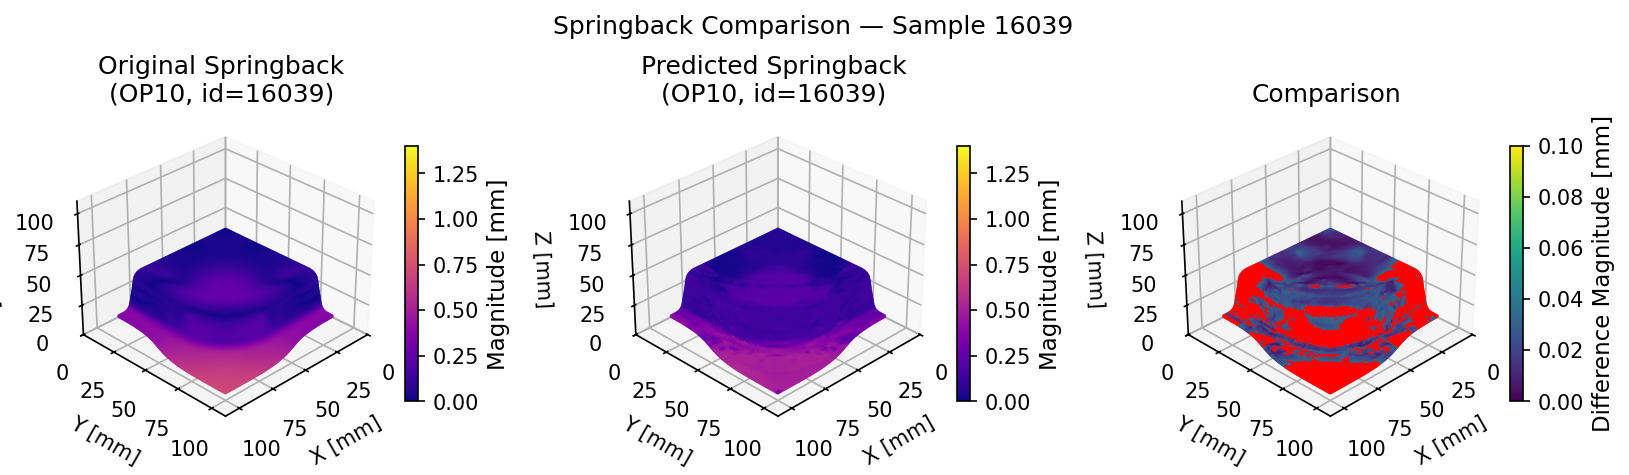

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import ticker
from pathlib import Path
import matplotlib as mpl
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10                    
TIMESTEP    = 2                    
sample_id   = "16039"              
#pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like/prediction/ddacs-node-regression/preds_new"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/graphormer_like/prediction/ddacs-node-regression/preds_new"
data_root   = "/mnt/data/jiang"     
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh 
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback 
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)  

# Compute magnitudes 
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm] np.linalg.norm(..., axis=1) takes the Euclidean (L2) norm row-wise
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector  = disp_pred - disp_gt
difference_mag  = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth    : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction  : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# All panels plotted at the same coordinates (GT final coords) for easy comparison.
# If undeformed mesh: use coords_plot = node_coords
# If predicted final pose: use coords_plot = node_coords + disp_pred
coords_plot = node_coords + disp_gt  

# plotting with existing routine
global_springback_min = 0.0
global_springback_max = 1.4
norm = Normalize(vmin=global_springback_min, vmax=global_springback_max)
global_springback_min_difference = 0.0
global_springback_max_difference = 0.3
norm_difference = Normalize(vmin=global_springback_min_difference, vmax=global_springback_max_difference) 


fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Create color
col1  = plt.cm.plasma(norm(mag_gt))
col2  = plt.cm.plasma(norm(mag_pred))
col3  = plt.cm.viridis(norm_difference(difference_mag))

threshold = 0.1  # mm
bright_color = np.array([1,0,0,1])  

# col1[mag_gt < threshold] = bright_color
# col2[mag_pred < threshold] = bright_color
col3[difference_mag > threshold] = bright_color

# # colorbar-specific colormaps & norms so the bar shows the bright under-range
# cmap_plasma_cb  = plt.cm.get_cmap("plasma").copy()
cmap_viridis_cb = plt.cm.get_cmap("viridis").copy()
# cmap_plasma_cb.set_under(bright_color)
cmap_viridis_cb.set_under(bright_color)

# norm_cb        = Normalize(vmin=threshold, vmax=global_springback_max)
#norm_diff_cb   = Normalize(vmin=threshold, vmax=global_springback_max_difference)
norm_diff_cb   = Normalize(vmin=0, vmax=threshold)

# Figure 1: Original magnitude 
ax1 = fig.add_subplot(131, projection="3d")
p1 = ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# Figure 2: Pred magnitude 
ax2 = fig.add_subplot(132, projection="3d")

p2 = ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm), "Magnitude [mm]")
# add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap=cmap_plasma_cb, norm=norm_cb), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# Figure 3: Difference magnitude ||pred - gt|| 
ax3 = fig.add_subplot(133, projection="3d")
p3 = ax3.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col3, s=1, alpha=0.95)
# add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap="viridis", norm=norm_difference), "Difference Magnitude [mm]")
add_colorbar(fig, ax3, plt.cm.ScalarMappable(cmap=cmap_viridis_cb, norm=norm_diff_cb), "Difference Magnitude [mm]")
ax3.set_title("Comparison")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison — Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")

save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
fig.savefig(save_dir / f"springback_id{sample_id}_lfpe.png",
            dpi=150,                 # pixel density (inches × dpi = pixels)
            bbox_inches="tight",     # trim extra margins
            pad_inches=0.1) 

plt.show()

